In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import os
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [3]:
torchvision.__version__

'0.10.0+cu102'

In [ ]:
%%capture
! pip install --upgrade albumentations
!pip install pkbar
import pkbar
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/DR Classification/DIP'
if os.getcwd() is not path:
  os.chdir(path)
master = 'Master Data'
csv_path = 'directory.csv'

In [ ]:
from dataset import *
from models import *
from utils import *

In [ ]:
device = torch.device('cuda')
batch_size = 4

In [ ]:
transforms = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.RandomRotate90(p=0.5),
     A.CLAHE(p=1),
     A.RandomBrightnessContrast(p=0.8),
     A.RandomGamma(p=0.8),
     ToTensorV2()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_classes']))

In [ ]:
dataset = RED_RCNN_Dataset(root=master, transforms=transforms, csv_path=csv_path)

generator = torch.Generator().manual_seed(7)
indices = torch.randperm(dataset.__len__(), generator = generator).tolist()
# Data split - 70%, 20%, 10%
train_dataset = Subset(dataset, indices[:-390])
val_dataset = Subset(dataset, indices[-390:-130])
test_dataset = Subset(dataset, indices[-130:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

#Training

In [ ]:
model = RED_RCNN(num_classes = 3, connection_type = 't3')

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
def IOU_LOSS(scores, targets, smooth=1e-5):
    iou = []
    t_labels = targets['labels']
    t_masks = targets['masks']
    s_labels = scores['labels']
    s_masks = scores['masks']
    t_masks = torch.flatten(t_masks, start_dim=1, end_dim=2) #(2, 512*512)
    s_masks = torch.flatten(s_masks, start_dim=1, end_dim=3) #(100, 512*512)
    # print(t_masks.shape, s_masks.shape) #(2,262144), (100,262144)

    for i in range(len(s_labels)):
      intersection = (s_masks[i]*t_masks[s_labels[i]-1]).sum()
      union = (s_masks[i] + t_masks[s_labels[i]-1] - s_masks[i]*t_masks[s_labels[i]-1]).sum()
      iou.append(1 - ((intersection)/(union + smooth))) #IoU Loss
    
    a = torch.sum(torch.Tensor(iou))
    return a

In [ ]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=0, verbose=True)
num_epochs = 80

load = 1
check_pt_file = 'Weights/redrcnn_t3_8th_1e-2_al_upto50_new.pth.tar'

In [ ]:
def do_train():
  print('Training is started.')
  train_per_epoch = len(train_loader)
  val_per_epoch = len(val_loader)
  min_loss = math.inf
  loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'iou']
  a = 0.7
  for epoch in range(num_epochs):
    train_params = {i: [] for i in loss_types}
    model.train()
    kbar_train = pkbar.Kbar(target = train_per_epoch, epoch = epoch, num_epochs = num_epochs)
    for batch_idx, (images, targets) in enumerate(train_loader):
      images, targets = process_data(images, targets, batch_size, device)

      loss_dict = model(images, targets, mode = 'train')
      train_scores = model(images, mode = 'eval')

      # Calculate IOU loss.
      loss_dict['iou'] = []
      for i in range(batch_size):
        loss_dict['iou'].append(IOU_LOSS(train_scores[i], targets[i]))
      loss_dict['iou'] = np.sum(loss_dict['iou']) #sum(l for l in np.array(loss_dict['iou_loss']))

      losses = sum(loss for loss in loss_dict.values())# - 2*loss_dict['iou']
      losses = losses + (a-1)*loss_dict['loss_mask'] + (-a)*loss_dict['iou']

      for (key, loss) in loss_dict.items():
        train_params[key].append(loss.item())
    
      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      kbar_train.update(batch_idx+1, values=[(key, params[-1]) for (key, params) in train_params.items()])
    mean_train_params = {}
    for (key, params) in train_params.items():
      mean_train_params[key] = np.mean(params)
    
    val_params = {i: [] for i in loss_types}
    kbar_val = pkbar.Kbar(target = val_per_epoch, epoch = epoch, num_epochs = num_epochs)
    with torch.no_grad():
      model.eval()
      for batch_idx, (images, targets) in enumerate(val_loader):
        images, targets = process_data(images, targets, batch_size, device)

        val_loss_dict = model(images, targets, mode = 'train')
        val_scores = model(images, mode = 'eval')
        # val_losses = sum(loss for loss in val_loss_dict.values())

        # Calculate IOU loss.
        val_loss_dict['iou'] = []
        for i in range(batch_size):
          val_loss_dict['iou'].append(IOU_LOSS(val_scores[i], targets[i]))
        val_loss_dict['iou'] = np.sum(val_loss_dict['iou'])

        # val_losses = sum(loss for loss in val_loss_dict.values())
        # val_losses = val_losses + (a-1)*val_loss_dict['loss_mask'] + (-a)*val_loss_dict['iou']

        for (key, loss) in val_loss_dict.items():
          val_params[key].append(loss.item())
      
        kbar_val.update(batch_idx+1, values=[(key, params[-1]) for (key, params) in val_params.items()])
      mean_val_params = {}
      for (key, params) in val_params.items():
        mean_val_params[key] = np.mean(params)
      
      aug_loss = a*mean_val_params['loss_mask'] + (1-a)*mean_val_params['iou']

      if lr_scheduler is not None:
        lr_scheduler.step(aug_loss)
        print('\tCurrent a:', a)
      a = a - 0.01

      if aug_loss < min_loss:
        min_loss = aug_loss
        print('\nImproved validation loss: {:.4f}'.format(min_loss))
        save_checkpoint(model, optimizer, check_pt_file)
        print('Model saved to {}\n'.format(check_pt_file))

In [ ]:
if load==0:
  do_train()

#Testing

In [ ]:
net, _ = load_checkpoint(model, optimizer, check_pt_file, device = device)

x, y = next(iter(test_loader))
x, y = process_data(x, y, batch_size, device)
net.eval()
yhat = net(x, mode='eval')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
print('INPUT')
for i in x:
  print(type(i), i.shape)

print('GT')
for i in y:
  for j in i:
    print(j, type(i[j]), i[j].shape)
  print('------')

print('PRED')
for i in yhat:
  for j in i:
    print(j, type(i[j]), i[j].shape)
  print('------')

INPUT
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
GT
boxes <class 'torch.Tensor'> torch.Size([2, 4])
labels <class 'torch.Tensor'> torch.Size([2])
masks <class 'torch.Tensor'> torch.Size([2, 512, 512])
image_id <class 'torch.Tensor'> torch.Size([1])
area <class 'torch.Tensor'> torch.Size([2])
iscrowd <class 'torch.Tensor'> torch.Size([2])
------
boxes <class 'torch.Tensor'> torch.Size([2, 4])
labels <class 'torch.Tensor'> torch.Size([2])
masks <class 'torch.Tensor'> torch.Size([2, 512, 512])
image_id <class 'torch.Tensor'> torch.Size([1])
area <class 'torch.Tensor'> torch.Size([2])
iscrowd <class 'torch.Tensor'> torch.Size([2])
------
boxes <class 'torch.Tensor'> torch.Size([2, 4])
labels <class 'torch.Tensor'> torch.Size([2])
masks <class 'torch.Tensor'> torch.Size([2, 512, 512])
image_id <class 'torch.Tensor'> torch.Size([1])
area <cl

In [ ]:
idx = 2 # data in a batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


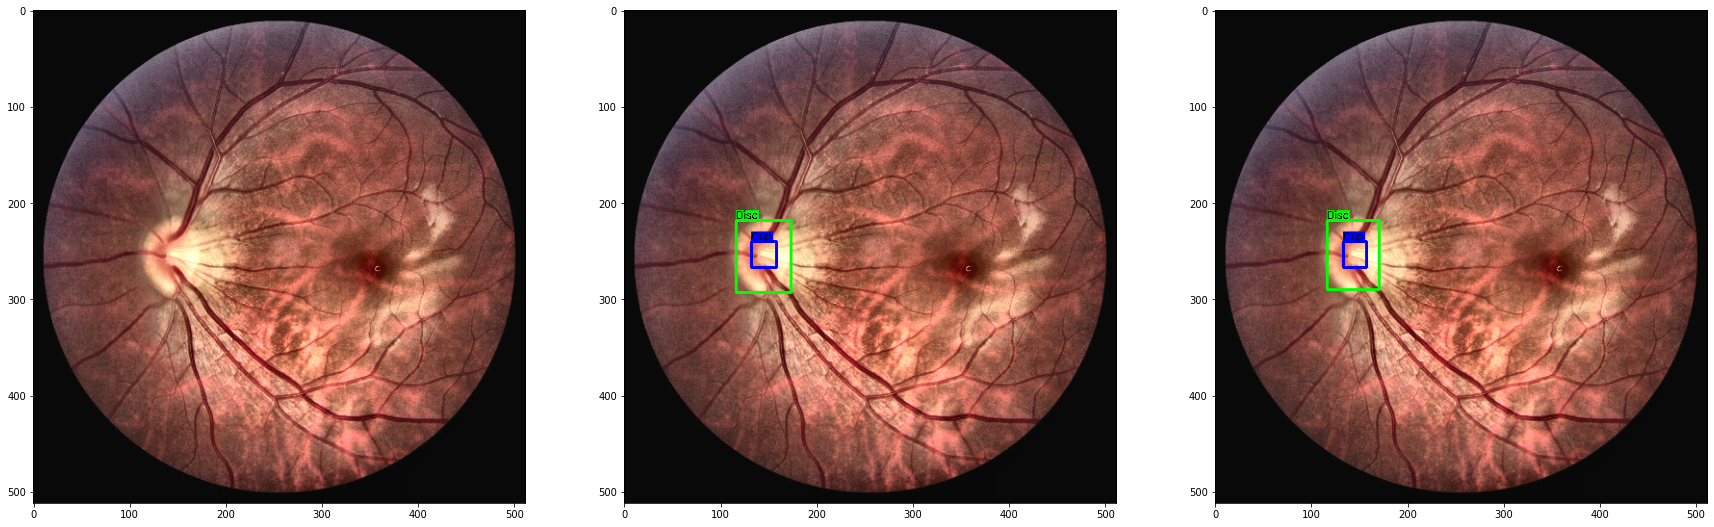

In [ ]:
fig = plt.figure(figsize=(30,15))

img = x[idx].cpu().permute(1,2,0).numpy()

img_bb = visualize(img, y[idx]['boxes'].cpu(), y[idx]['labels'].cpu())
# print(y[idx]['boxes'].cpu(), y[idx]['labels'].cpu())
img_bb_pred = visualize(img, yhat[idx]['boxes'].cpu().detach().numpy().astype(int), yhat[idx]['labels'].cpu().detach().numpy())
# print(yhat[idx]['boxes'].cpu().detach().numpy().astype(int), yhat[idx]['labels'].cpu().detach().numpy())
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_bb)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_bb_pred)
plt.show()

In [ ]:
def thresh(x):
  y = np.zeros_like(x)
  y[x>0.9] = 1.0
  return y

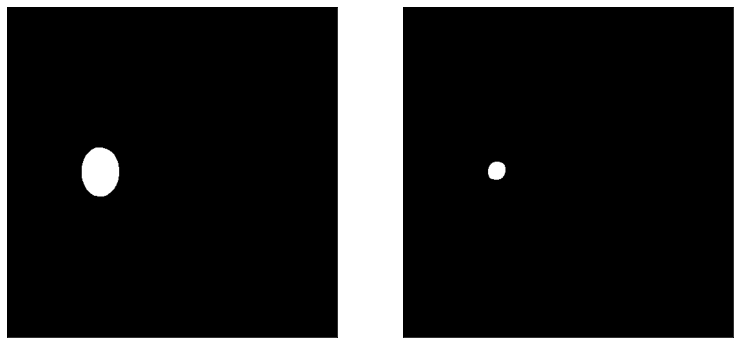

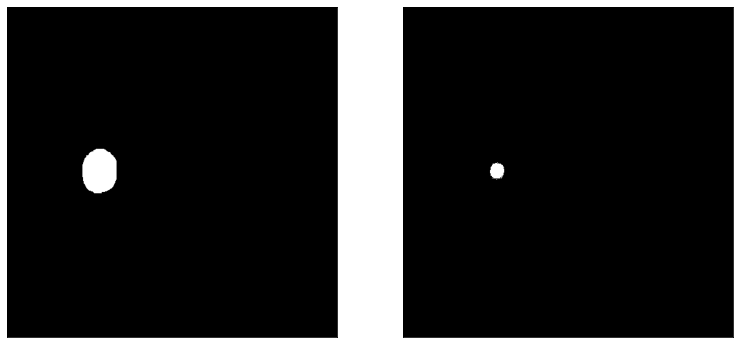

In [ ]:
s=(13,13)
fig = plt.figure(figsize=s)
for i in range(2):
  ax1 = fig.add_subplot(1,2,i+1)
  ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
  ax1.imshow(y[idx]['masks'].cpu()[i], 'gray')
plt.show()

fig = plt.figure(figsize=s)
s = yhat[idx]['masks'].shape
for i in range(s[0]):
  ax1 = fig.add_subplot(1,s[0],i+1)
  ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
  ax1.imshow(thresh(yhat[idx]['masks'][i, 0].cpu().detach().numpy()), 'gray')
plt.show()

# fig = plt.figure(figsize=(10,5))
# for i in range(s[0]):
#   ax1 = fig.add_subplot(1,s[0],i+1)
#   ax1.imshow(yhat[idx]['masks'][i, 0].cpu().detach().numpy(), 'gray')
# plt.show()

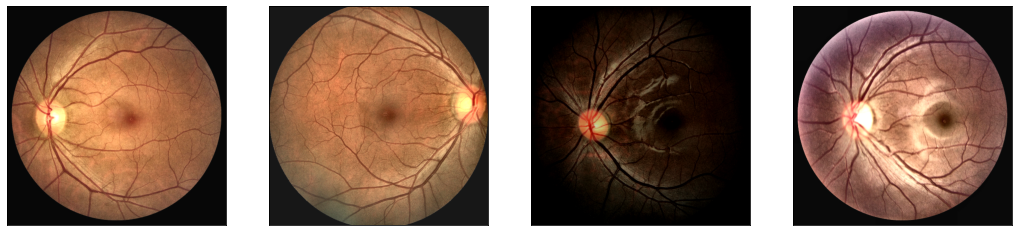

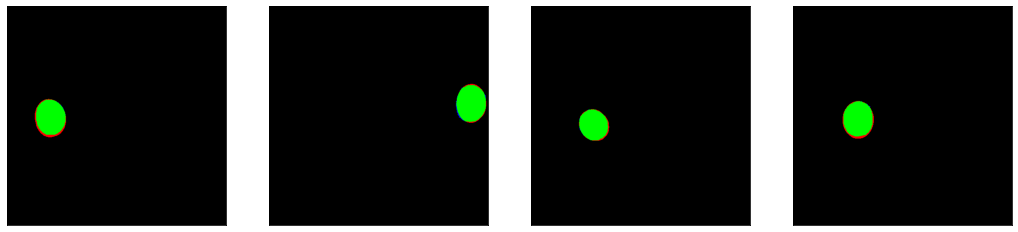

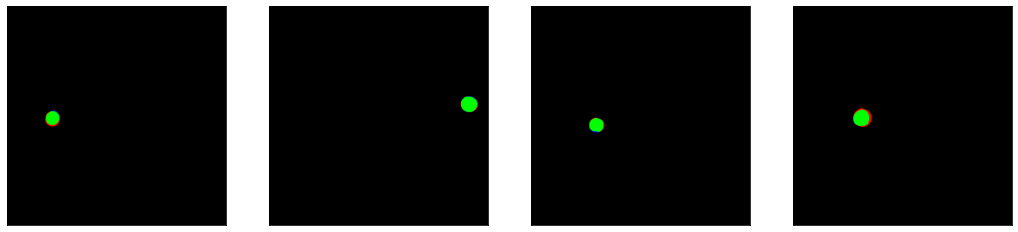

In [ ]:
sz=(18,18)
fig = plt.figure(figsize=sz)
for i in range(batch_size):
  img = x[i].cpu().permute(1,2,0).numpy()

  ax1 = fig.add_subplot(1,4,i+1)
  ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
  ax1.imshow(img)
plt.show()

fig = plt.figure(figsize=sz)
for i in range(batch_size):
  p = thresh(yhat[i]['masks'][0,0].cpu().detach().numpy())
  g = y[i]['masks'].cpu()[0]

  a = np.zeros(p.shape)
  a = 2*g+p
  b = np.zeros(p.shape+(3,))
  b[a==3] = [0,255,0]
  b[a==2] = [255,0,0]
  b[a==1] = [0,0,255]

  ax1 = fig.add_subplot(1,4,i+1)
  ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
  ax1.imshow(b/255.)
plt.show()

fig = plt.figure(figsize=sz)
for i in range(batch_size):
  p = thresh(yhat[i]['masks'][1,0].cpu().detach().numpy())
  g = y[i]['masks'].cpu()[1]

  a = np.zeros(p.shape)
  a = 2*g+p
  b=np.zeros(p.shape+(3,))
  b[a==3] = [0,255,0]
  b[a==2] = [255,0,0]
  b[a==1] = [0,0,255]

  ax1 = fig.add_subplot(1,4,i+1)
  ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
  ax1.imshow(b/255.)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


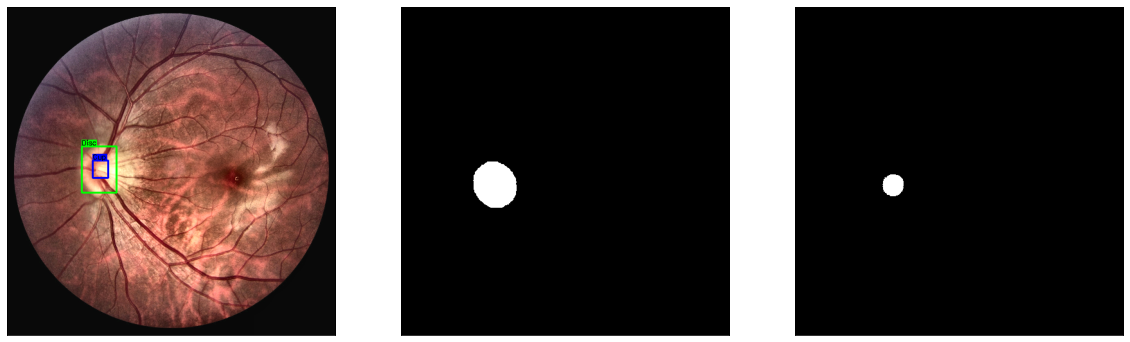

In [ ]:
fig = plt.figure(figsize=(20,10))
ax3 = fig.add_subplot(1,3,1)
ax3.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
ax3.imshow(img_bb_pred)
s = yhat[idx]['masks'].shape
for i in range(s[0]):
  ax1 = fig.add_subplot(1,s[0]+1,i+2)
  ax1.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
  ax1.imshow(thresh(yhat[idx]['masks'][i, 0].cpu().detach().numpy()), 'gray')
plt.show()

In [ ]:
def get_all_preds(model, loader, device=device):
    all_preds = torch.tensor([], device=device)
    all_labels = torch.tensor([], device=device)
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels
        _, trues = torch.max(labels, dim=1)
        trues = torch.flatten(trues, start_dim=0, end_dim=-1)

        scores = model(images) #(4,3,512,512)
        _, preds = torch.max(scores, dim=1) #(4,512,512)
        preds = torch.flatten(preds, start_dim=0, end_dim=-1)

        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, trues),dim=0)
    return all_preds, all_labels

#Classification

In [ ]:
def find_vcdr(boxes, labels):
  dic = {int(labels[i]):boxes[i].cpu().numpy() for i in range(len(labels))}
  od = dic[1][3] - dic[1][1]
  oc = dic[2][3] - dic[2][1]
  return oc/od
def find_class(id):
  df = pd.read_csv(csv_path)
  return df.iloc[id, 3]

In [ ]:
th_ratio = 0.6
tloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
net, _ = load_checkpoint(model, optimizer, check_pt_file, device = device)
net.eval()
y_t = []
y_p = []
print('SNo.', 'ID', 'VCDR', 'VCDR_P', 'CLASS', 'CLASS_P', sep='\t')
n=0
cm = [0,0,0,0] #tn, fp, fn, tp
c=0
with torch.no_grad():
  for x, y in tloader:
    x, y = process_data(x, y, batch_size, device)
    yhat = net(x, 'eval')
    for i in range(batch_size):
      cdr = find_vcdr(y[i]['boxes'], y[i]['labels'])
      id = int(y[i]['image_id'])
      g_type = find_class(id)

      cdr_p = find_vcdr(yhat[i]['boxes'], yhat[i]['labels'])
      g_type_p = int(cdr_p>th_ratio)
      y_t.append(g_type)
      y_p.append(g_type_p)

      print(n+1, id, cdr, cdr_p, g_type, g_type_p, sep='\t\t')
      
      a = g_type*2 + g_type_p
      cm[a]+=1
      c+=(g_type==g_type_p)
      n+=1

print('\nAccuracy: Got {} correct out of {}.'.format(c, n))

SNo.	ID	VCDR	VCDR_P	CLASS	CLASS_P
1		343		0.4444444444444444		0.4820229		0		0
2		531		0.5425531914893617		0.578584		1		0
3		431		0.4925373134328358		0.4478774		0		0
4		441		0.36231884057971014		0.40028656		0		0
5		766		0.32978723404255317		0.75284684		0		1
6		1172		0.38271604938271603		0.40352473		0		0
7		183		0.5070422535211268		0.4552968		0		0
8		1000		0.425		0.44464964		0		0
9		488		0.4084507042253521		0.40489277		0		0
10		1216		0.41935483870967744		0.43026182		0		0
11		597		0.4235294117647059		0.45294		0		0
12		107		0.4827586206896552		0.45610562		0		0
13		907		0.7738095238095238		0.81804067		1		1
14		587		0.4605263157894737		0.40515524		0		0
15		957		0.47058823529411764		0.42460558		0		0
16		995		0.4583333333333333		0.43944907		0		0
17		88		0.822429906542056		0.6480437		1		1
18		589		0.3918918918918919		0.47208762		0		0
19		567		0.569620253164557		0.47993824		0		0
20		390		0.4852941176470588		0.46475312		0		0
21		900		0.46153846153846156		0.50388986		0		0
22		62		0.747368421052631

In [ ]:
print(y_t)
print(y_p)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, jaccard_score, classification_report

In [ ]:
def res():
  c = confusion_matrix(y_t, y_p)
  print('Confusion Matrix \n {}\n'.format(c))
  print('Accuracy {}'.format(accuracy_score(y_t, y_p)))
  print('Precision {}'.format(precision_score(y_t, y_p, average = None)))
  print('Recall {}'.format(recall_score(y_t, y_p, average=None)))
  print('F1 Score {}'.format(f1_score(y_t, y_p, average = None)))
  print('Jaccard Score {}'.format(jaccard_score(y_t, y_p, average = None)))
  print('Weighted Averages')
  print('Precision {}'.format(precision_score(y_t, y_p, average = 'weighted')))
  print('Recall {}'.format(recall_score(y_t, y_p, average='weighted')))
  print('F1 Score {}'.format(f1_score(y_t, y_p, average = 'weighted')))
  print('Jaccard Score {}'.format(jaccard_score(y_t, y_p, average = 'weighted')))
  # print('\n', check_pt_file)
res()

Confusion Matrix 
 [[101   9]
 [  6  12]]

Accuracy 0.8828125
Precision [0.94392523 0.57142857]
Recall [0.91818182 0.66666667]
F1 Score [0.93087558 0.61538462]
Jaccard Score [0.87068966 0.44444444]
Weighted Averages
Precision 0.8915428905206944
Recall 0.8828125
F1 Score 0.8865096596951436
Jaccard Score 0.8107489224137931


In [ ]:
print(cm)

[101, 9, 6, 12]


In [ ]:
c = np.array([[2776349,69884,54492],[12032,89630,12874],[12049,19325,99093]])

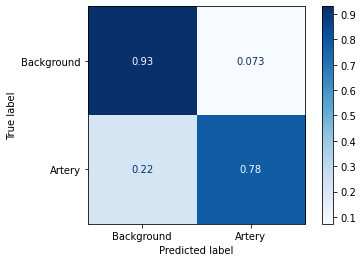

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# c = c.astype('float') / c.sum(axis=1)[:, np.newaxis]
c = np.array([[0.93, 0.073], [0.22, 0.78]])
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=['Background', 'Artery', 'Vein'])
disp.plot(cmap='Blues')
plt.show()